# TODO

- change arm_df name to all_years_armd_df or all_years_im_df
- perhaps ImpactTrajectory or ImpactMetrics instead of RiskMertics
- Update the calc_measure_cash_flows_df

# Updates from old CB 

Lists (make a table)


**CB metrics**
- Resiudal risk = 
    - Ols 
- Avergae annual risk


# CB Refactoring

In [1]:
import numpy as np

from climada.util.api_client import Client
from climada.entity import ImpactFunc

from climada.entity import LitPop

import copy
client = Client()


## Parameters

In [2]:
# Parameters
ctr_str = 'BEL' #'DEU'

# Years to be considered
years = [2000, 2020, 2050]

# 1 – Create the snapshot collection 

## Exposure

In [3]:
exp_hist = LitPop().from_countries(countries=ctr_str, reference_year=years[0])

# Assign random Group_id of 3 possible to the gdf
reg_id_arr = np.random.randint(0, 3, exp_hist.gdf.shape[0])
exp_hist.gdf['region_id'] = reg_id_arr

# Present
exp_pres = LitPop().from_countries(countries=ctr_str, reference_year=years[1])
# Assign the region_ids
exp_pres.gdf['region_id'] = reg_id_arr

# Future
exp_fut = copy.deepcopy(exp_pres)
# Exponential growth
exp_growth_rate = 0.01
exp_fut.gdf.value = exp_fut.gdf.value * (1 + exp_growth_rate)**(years[2] - years[1])
# Assign the region_ids
exp_fut.gdf['region_id'] = reg_id_arr

2024-07-23 17:55:12,705 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: BEL (56)...

2024-07-23 17:55:13,075 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2024-07-23 17:55:13,076 - climada.entity.exposures.base - INFO - category_id not set.
2024-07-23 17:55:13,076 - climada.entity.exposures.base - INFO - cover not set.
2024-07-23 17:55:13,077 - climada.entity.exposures.base - INFO - deductible not set.
2024-07-23 17:55:13,077 - climada.entity.exposures.base - INFO - centr_ not set.
2024-07-23 17:55:14,919 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: BEL (56)...

2024-07-23 17:55:15,586 - climada.util.finance - INFO - GDP BEL 2014: 5.354e+11.
2024-07-23 17:55:15,937 - climada.util.finance - INFO - GDP BEL 2020: 5.260e+11.
2024-07-23 17:55:15,953 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2024-07-23 17:55:15,953 - climada.entity.exposures.base - INFO - categ

## Hazard sets

In [4]:
haz_fl_1980 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'historical',
        'year_range': '1980_2000',
        'country_iso3alpha': 'DEU'
    })

haz_fl_2010 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'rcp85',
        'year_range': '2010_2030',
        'country_iso3alpha': 'DEU'
    })

haz_fl_2030 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'rcp85',
        'year_range': '2030_2050',
        'country_iso3alpha': 'DEU'
    })

2024-07-23 17:55:21,475 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/river_flood/river_flood_150arcsec_hist_DEU_1980_2000/v2/river_flood_150arcsec_hist_DEU_1980_2000.hdf5
2024-07-23 17:55:27,138 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/river_flood/river_flood_150arcsec_rcp85_DEU_2010_2030/v3/river_flood_150arcsec_rcp85_DEU_2010_2030.hdf5
2024-07-23 17:55:33,121 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/river_flood/river_flood_150arcsec_rcp85_DEU_2030_2050/v3/river_flood_150arcsec_rcp85_DEU_2030_2050.hdf5


## Impact Functions

array([<Axes: title={'center': 'RF 1: Flood Africa JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
       <Axes: title={'center': 'RF 2: Flood Asia JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
      dtype=object)

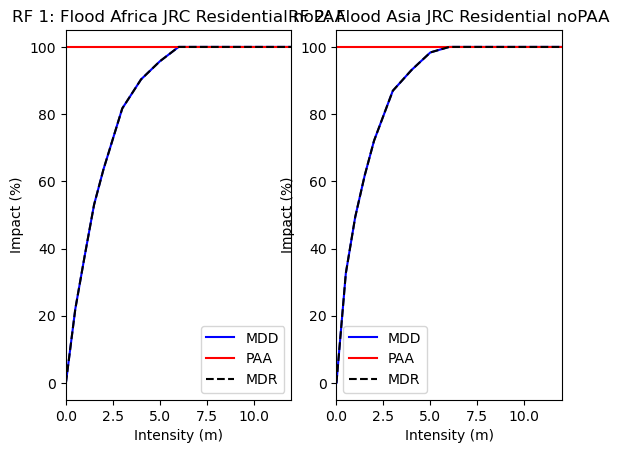

In [5]:
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood, flood_imp_func_set
from climada.entity import ImpactFunc, ImpactFuncSet

impf_set_flood = flood_imp_func_set()

impf_1 = impf_set_flood.get_func(fun_id=1, haz_type='RF')
impf_2 = impf_set_flood.get_func(fun_id=2, haz_type='RF')
impfset = ImpactFuncSet([impf_1, impf_2])


impfset.plot()

### Assign Impact Functions ID to the exposures

In [6]:
def assign_impfid(exp_hist, exp_pres, exp_fut, case='single'):
    if case=='single':
        exp_hist.gdf['impf_RF'] = 1
        exp_pres.gdf['impf_RF'] = 1
        exp_fut.gdf['impf_RF'] = 1
    if case=='multiple_spatial':
        exp_hist.gdf.loc[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_pres.gdf[:len(exp_pres.gdf/2),'impf_RF'] = 1
        exp_fut.gdf[:len(exp_fut.gdf/2),'impf_RF'] = 1
        exp_hist.gdf.loc[len(exp_hist.gdf/2):,'impf_RF'] = 2
        exp_pres.gdf[len(exp_pres.gdf/2):,'impf_RF'] = 2
        exp_fut.gdf[len(exp_fut.gdf/2):,'impf_RF'] = 2
    if case=='multiple_temp':
        exp_hist.gdf['impf_RF'] = 1
        exp_pres.gdf['impf_RF'] = 1
        exp_fut.gdf['impf_RF'] = 2
    if case == 'multiple':
        exp_hist.gdf.loc[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_pres.gdf[:len(exp_hist.gdf/2),'impf_RF'] = 2
        exp_fut.gdf[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_hist.gdf.loc[len(exp_hist.gdf/2):,'impf_RF'] = 2
        exp_pres.gdf[len(exp_hist.gdf/2):,'impf_RF'] = 1
        exp_fut.gdf[len(exp_hist.gdf/2):,'impf_RF'] = 2

# Assign the impact functions to the exposure
assign_impfid(exp_hist, exp_pres, exp_fut, case='single')
assign_impfid(exp_hist, exp_pres, exp_fut, case='multiple_temp')

## Create the Snapshot Collection

In [7]:
from climada.engine.option_appraisal.impact_trajectories import Snapshot, SnapshotsCollection, CalcImpactsSnapshots

# Store the hazards and exposure in a list
hazard_list = [haz_fl_1980, haz_fl_2010, haz_fl_2030]
exposure_list = [exp_hist, exp_pres, exp_fut]
snapshot_years = years

# Create the snapshots
snapshots = SnapshotsCollection.from_lists( hazard_list, exposure_list, impfset, snapshot_years)


In [8]:
risk_transf_cover = 10000000000000
risk_transf_attach = 100000000

excl_risk_trans_df = CalcImpactsSnapshots(snapshots).calc_all_years(metrics=["aai"])
incl_risk_trans_df = CalcImpactsSnapshots(snapshots).calc_all_years(metrics=["aai"],
                                                                    risk_transf_cover=risk_transf_cover, 
                                                                    risk_transf_attach=risk_transf_attach, 
                                                                    calc_residual=True)
risk_trans_df = CalcImpactsSnapshots(snapshots).calc_all_years(metrics=["aai"],
                                                            risk_transf_cover=risk_transf_cover, 
                                                            risk_transf_attach=risk_transf_attach, 
                                                            calc_residual=False)

2024-07-23 17:55:33,510 - climada.entity.exposures.base - INFO - Matching 56125 exposures with 26472 centroids.
2024-07-23 17:55:33,523 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-23 17:55:33,598 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 36334 coordinates.
2024-07-23 17:55:33,601 - climada.engine.impact_calc - INFO - Calculating impact for 59373 assets (>0) and 920 events.
2024-07-23 17:55:33,613 - climada.entity.exposures.base - INFO - Matching 56125 exposures with 26472 centroids.
2024-07-23 17:55:33,623 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-23 17:55:33,691 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 36334 coordinates.
2024-07-23 17:55:33,695 - climada.engine.impact

In [9]:
excl_risk_trans_df.tail()

,group,year,metric,result
26,NaN,2046,aai,9.925554e+05
27,NaN,2047,aai,1.032889e+06
28,NaN,2048,aai,1.073808e+06
29,NaN,2049,aai,1.115314e+06
30,NaN,2050,aai,1.157406e+06


In [10]:
print(incl_risk_trans_df.tail())

   group  year metric         result
26   NaN  2046    aai  741736.014385
27   NaN  2047    aai  764565.989423
28   NaN  2048    aai  787400.012756
29   NaN  2049    aai  810238.084382
30   NaN  2050    aai  833080.204301


In [11]:
risk_trans_df.tail()

,group,year,metric,result
26,NaN,2046,aai,250819.402370
27,NaN,2047,aai,268322.932199
28,NaN,2048,aai,286408.434601
29,NaN,2049,aai,305075.909576
30,NaN,2050,aai,324325.357124


In [12]:
(risk_trans_df['result'] + incl_risk_trans_df['result']).tail()

26    9.925554e+05
27    1.032889e+06
28    1.073808e+06
29    1.115314e+06
30    1.157406e+06
Name: result, dtype: float64

## Define the measures and the measure set

In [13]:
# Define the measure
from climada.entity.measures.base import Measure, helper_hazard, helper_impfset, helper_exposure
from climada.entity.measures import MeasureSet
from climada.entity.measures.cost_income import CostIncome

# Add to measure set list
meas_list = []

# Measure
haz_func = helper_hazard(0.8, 0)
exp_func = helper_exposure(reassign_impf_id=1, haz_type='RF')
impfset_func = helper_impfset(haz_type='RF')
# CostIncome attributes
cost_inc_attr_dict = {'mkt_price_year': 2000, 'init_cost': -5_000_000_000, 'annual_cost': -5000, 'annual_income': 30_0, 'cost_growth_rate': 0.02, 'income_growth_rate': 0.07}

meas1 = Measure(
    name='Hazard_Int_Red_08', #start_year=2000, end_year=2050,
    exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func, haz_type = 'RF',
    cost_income = CostIncome(**cost_inc_attr_dict)
    )
meas_list.append(meas1)

# Measure
haz_func = helper_hazard(0.6, 0)
exp_func = helper_exposure(reassign_impf_id=1, haz_type='RF')
impfset_func = helper_impfset(haz_type='RF', impf_mdd_modifier={2: (0.6, 0)})
# CostIncome attributes
cost_inc_attr_dict = {'mkt_price_year': 2000, 'init_cost': -5_000_000_000, 'annual_cost': -600_0, 'annual_income': 350, 'cost_growth_rate': 0.02, 'income_growth_rate': 0.07}

meas2 = Measure(
    name='Hazard_Int_Red_07', #start_year=2015, end_year=2035,
    exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func, haz_type = 'RF',
    cost_income = CostIncome(**cost_inc_attr_dict)
    )
meas_list.append(meas2)

# Measure
haz_func = helper_hazard(0.5, 0)
exp_func = helper_exposure(reassign_impf_id=1, haz_type='RF')
impfset_func = helper_impfset(haz_type='RF', impf_mdd_modifier={2: (0.6, 0)})
# CostIncome attributes
cost_inc_attr_dict = {'mkt_price_year': 2000, 'init_cost': -5_000_000_000, 'annual_cost': -100, 'annual_income': 400, 'cost_growth_rate': 0.02, 'income_growth_rate': 0.07}
meas3 = Measure(
    name='Hazard_Int_Red_06', #start_year=2030, end_year=2040,
    exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func, haz_type = 'RF',
    cost_income = CostIncome(**cost_inc_attr_dict)
    )
meas_list.append(meas3)


# Create the measure set
measure_set = MeasureSet(meas_list)


# Step 2 - Analyze risk over time, measure cost vs benefit and path planing

## Step 2.1 – Calculate the annual impact metrics 

In [14]:
from climada.engine.option_appraisal.calc_impact_metrics import CalcImpactMetrics

cim = CalcImpactMetrics(snapshots)

# Calculate the impacts for the measures
im = cim.generate_impact_metrics(measure_set=measure_set, planner= {'Hazard_Int_Red_08': [2000, 2030], 
                                                                    'Hazard_Int_Red_06': [2000, 2030],
                                                                    'Hazard_Int_Red_07': [2040, 2050] })


2024-07-23 17:55:36,471 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-07-23 17:55:36,472 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-07-23 17:55:36,472 - climada.entity.exposures.base - INFO - Matching 56125 exposures with 26472 centroids.
2024-07-23 17:55:36,480 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-23 17:55:36,549 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 36334 coordinates.
2024-07-23 17:55:36,552 - climada.engine.impact_calc - INFO - Calculating impact for 59373 assets (>0) and 920 events.
2024-07-23 17:55:36,559 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-07-23 17:55:36,559 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-07-23 1

## 2.2 – Analysis: Risk and averted risk over time 

### 2.2.1 – Waterfall plots

* Allows to diplay the risk contribution of chnage in exposure, impact function and hazard (climate change)

In [15]:
# # Plot the classic waterfall
# im.waterfall_plot()

# # Plot the yearly waterfall
# im.waterfall_plot(yearly=True)

# # Parameters
# im.waterfall_plot(measure='Hazard_Int_Red_06', metric='aai')

### 2.2.2 – Risk over time

             measure  start_year  end_year
0  Hazard_Int_Red_08        2000      2030
0  Hazard_Int_Red_07        2040      2050
0  Hazard_Int_Red_06        2000      2030


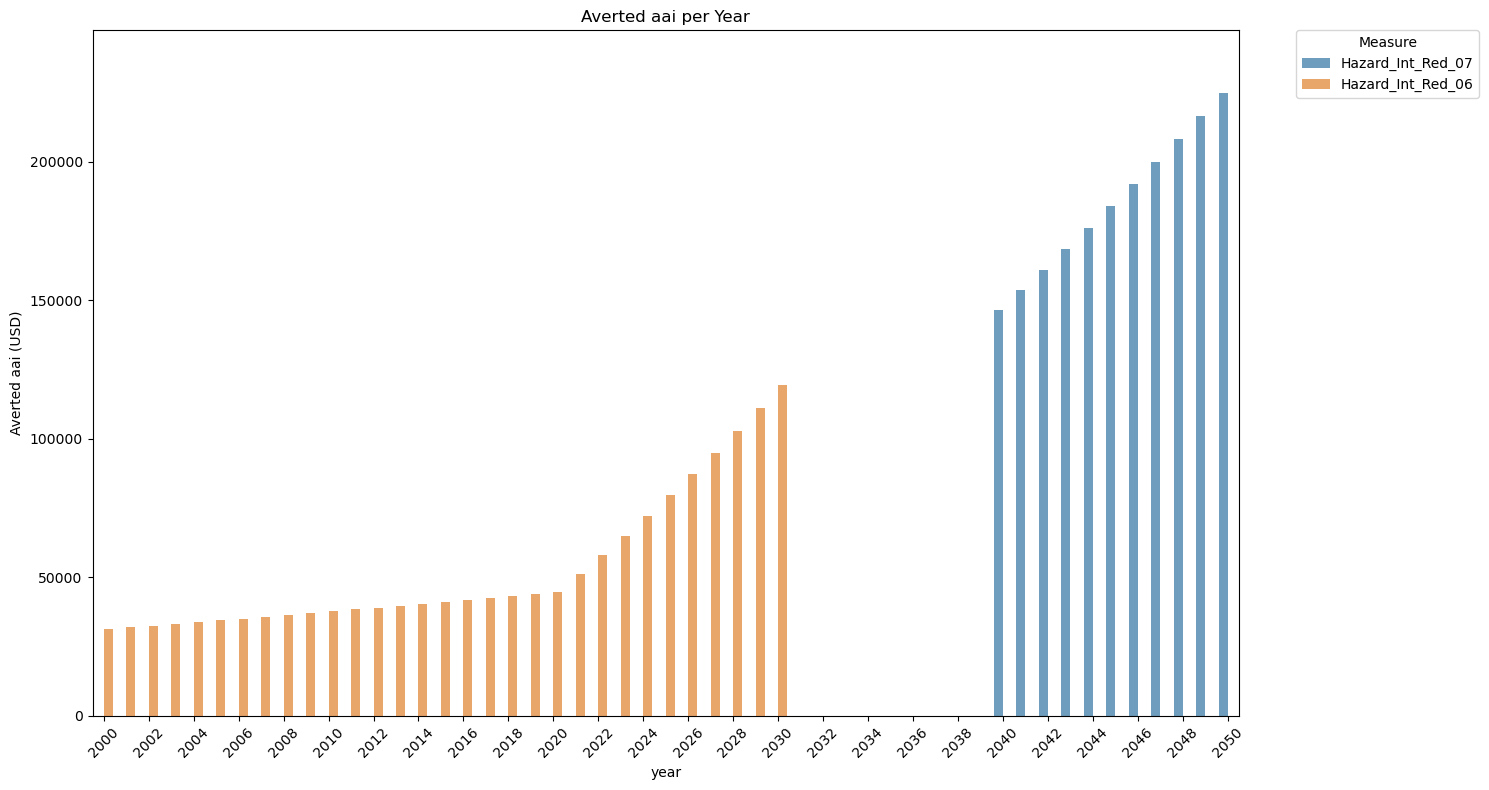

In [16]:
# Print the im.measure_times_df in tabular form
print(im.measure_times_df)


# Plot risk over time
#im.plot_yearly_risk_metrics()

# Plot risk over time - Bar
im.plot_yearly_risk_metrics(plot_type='bar', consider_measure_times=True, averted=True, measures=im.get_measures()[-2:])


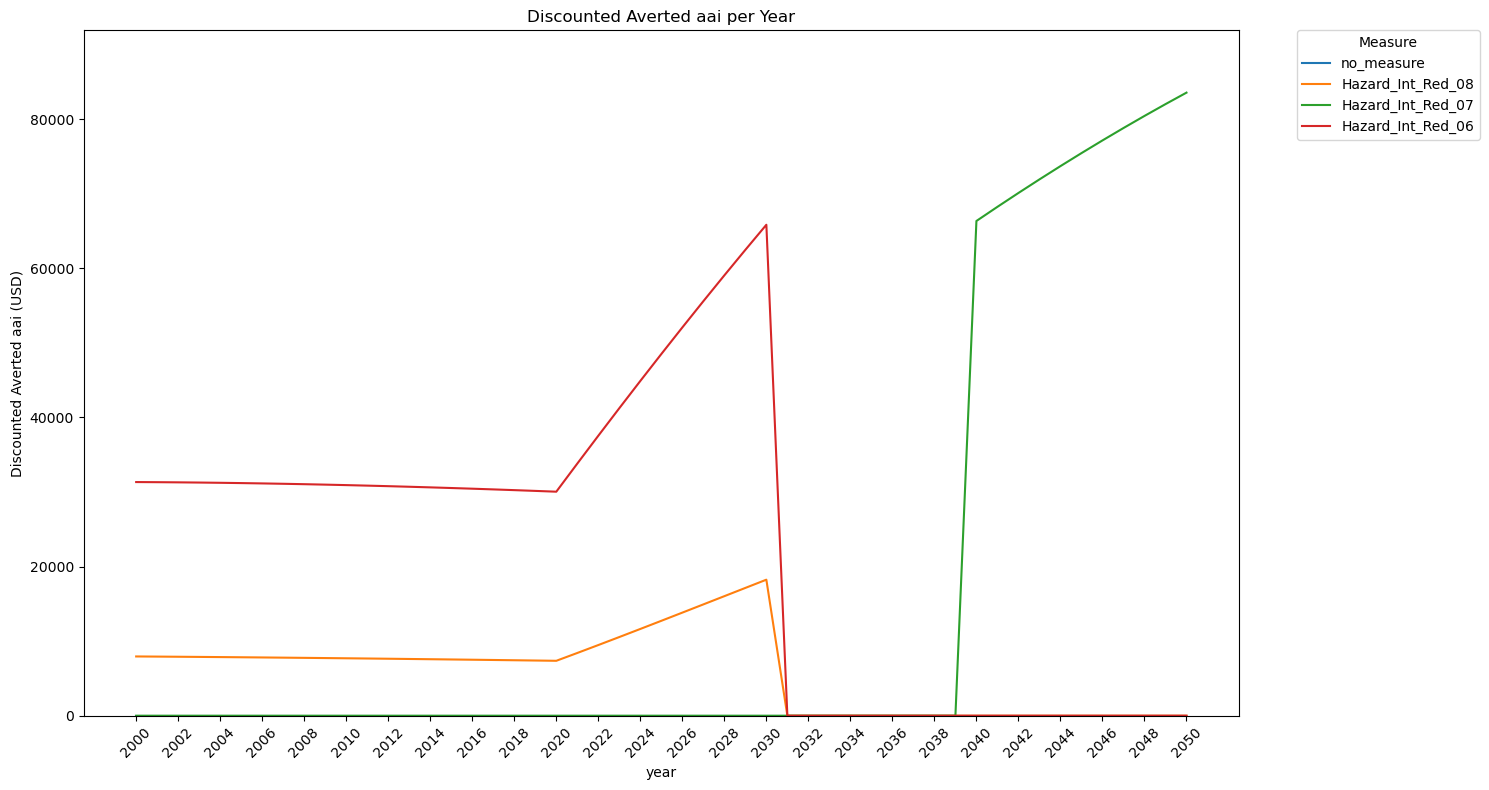

In [17]:
from climada.entity import DiscRates

# Plotting arguments
metric = im.get_risk_metrics()[0] # E.g., 'aai' or 'rp_1000', the risk metrics are found in im.get_metrics()[3]
averted= True # False or True – if True, the averted risk is plotted
consider_measure_times = True # False or True – if True, the measure srat and end times are considered for the risk calculation
risk_disc = DiscRates(years=np.arange(1900, 2100), rates=np.ones(np.arange(1900, 2100).size) * 0.02) # Discount rates for the risk metrics
plot_type='line' # 'line' or 'bar
measures = None #im.get_measures()[1:3] # ['Hazard_Int_Red_06', 'Hazard_Int_Red_07'] or None


# Plot the risk metrics
im.plot_yearly_risk_metrics(metric=metric, averted=averted, consider_measure_times=consider_measure_times, risk_disc=risk_disc, plot_type=plot_type, measures=measures)



### CB analysis

In [18]:
im.measure_times_df

,measure,start_year,end_year
0,Hazard_Int_Red_08,2000,2030
0,Hazard_Int_Red_07,2040,2050
0,Hazard_Int_Red_06,2000,2030


╒════╤═══════════════════╤════════════════╤═══════════════════╤══════════════════════╕
│    │ Measure           │   Cost (USD M) │   Benefit (USD M) │   Benefit/Cost Ratio │
╞════╪═══════════════════╪════════════════╪═══════════════════╪══════════════════════╡
│  0 │ Hazard_Int_Red_08 │       -5000.18 │              0.42 │                    0 │
├────┼───────────────────┼────────────────┼───────────────────┼──────────────────────┤
│  1 │ Hazard_Int_Red_07 │      -11040.3  │              2.03 │                    0 │
├────┼───────────────────┼────────────────┼───────────────────┼──────────────────────┤
│  2 │ Hazard_Int_Red_06 │       -4999.96 │              1.63 │                    0 │
╘════╧═══════════════════╧════════════════╧═══════════════════╧══════════════════════╛

--------------------  ---------
Total climate risk:          21.49  (USD M)
Average annual risk:          0.42  (USD M)
Residual risk:               19.46  (USD M)
--------------------  ---------


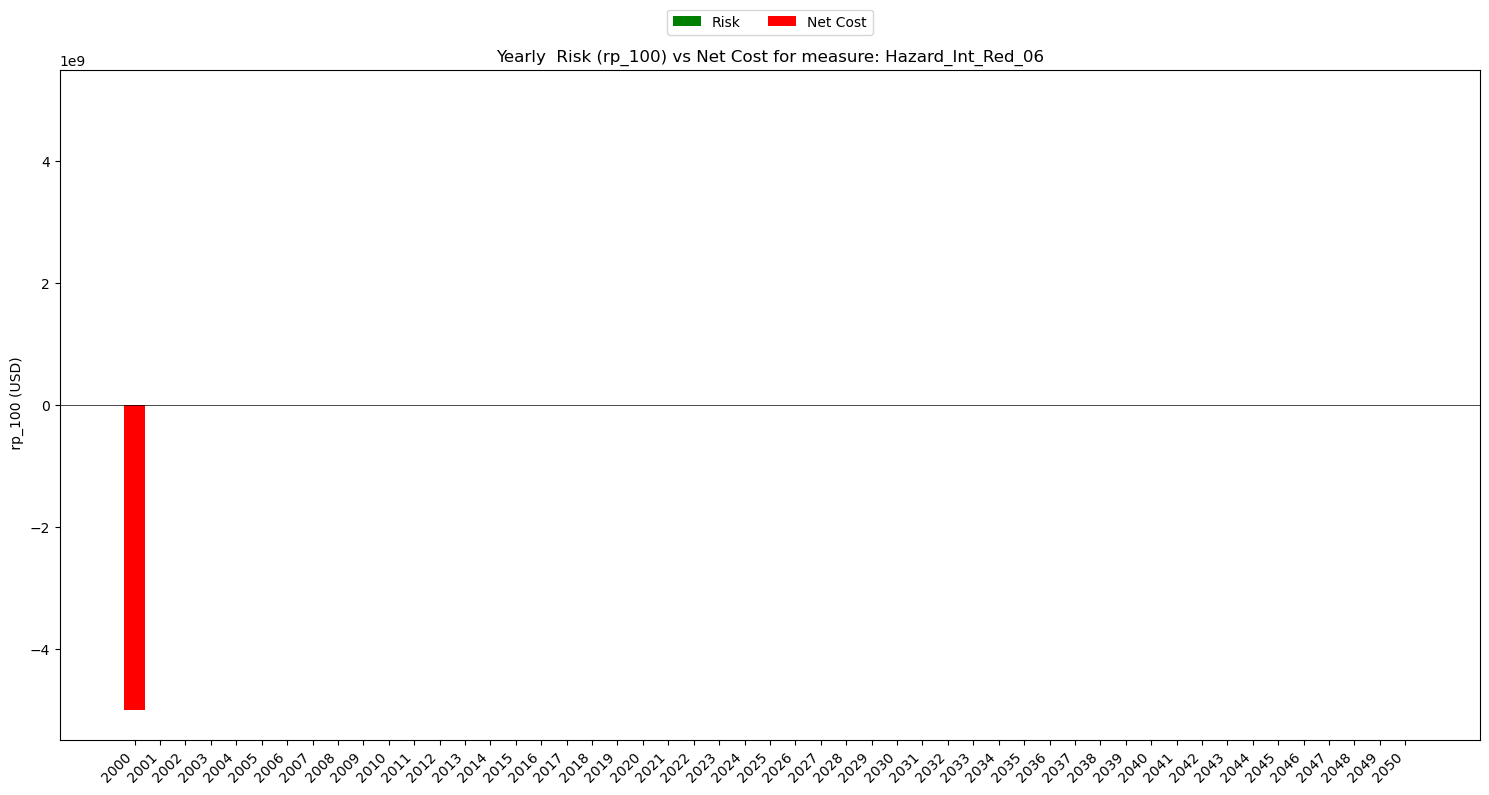

In [19]:
# Cost-benefit analysis
# Print the cost-benefit summary table
im.print_CB_summary_table(consider_measure_times=True, risk_disc=None, cost_disc=None)


# Plot the yearly averted cost for a specific measure
im.plot_benefit_vs_cost(measure='Hazard_Int_Red_06', metric='rp_100', risk_disc=None, cost_disc=None, consider_measure_times=True)

# Step 3 - Path planing 

In [20]:
# Update the planner
im.update_planner(planner = {'Hazard_Int_Red_08': [2030, 2032]})

UnboundLocalError: local variable 'all_combos_exist' referenced before assignment

In [ ]:
im.plot_yearly_risk_metrics(metric='aai', averted=True, consider_measure_times=True, risk_disc=None, plot_type='line')

In [ ]:
im_new = cim.generate_impact_metrics(measure_set=measure_set, planner= {'Hazard_Int_Red_08': [2035, 2050], 
                                                                    'Hazard_Int_Red_06': [2000, 2030],
                                                                    'Hazard_Int_Red_07': [2040, 2050] }, previous_impact_metrics=im)

In [ ]:
im_new.plot_yearly_risk_metrics(plot_type='bar', consider_measure_times=True, averted=True, measures=im_new.get_measures()[-3:])

# Step 4 - MCDM analysis

### Generate the MCDM data frame

In [ ]:
from climada.engine.option_appraisal.MCDM.DecisionMatrix import DecisionMatrix  # Import DecisionMatrix module
from tabulate import tabulate

# Create the DecisionMatrix object
metrics_df = im.generate_MCDM_dataframe()
alt_cols = ['measure']
crit_cols = [col for col in metrics_df.columns if 'tot_' in col or 'avrt_' in col or 'cost_' in col]
objectives = {crit: 1 if 'cost' in crit or 'avrt' in crit else -1 for crit in crit_cols}

dm = DecisionMatrix(metrics_df=metrics_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols, group_cols=['group'])

### Plot the criteria and weights

In [ ]:
# Print the alternatives
print('The available alternatives are:')
print('---------------------------')
print(tabulate(dm.alternatives_df, headers='keys', tablefmt='psql'))

# Plot the criteria weights
dm.plot_criteria()

# Rank the alternatives
ranks_output = dm.calc_rankings()

# Rank the alternatives
ranks_output = dm.calc_rankings()

### Perform ranking

In [ ]:
# *************** User-modifiable parameters ***************

disp_rnk_cols = [] # Select specifc columns to display in the rankings
sort_by_col = 'copeland' # Select the column to sort the rankings by
alt_name_col = 'measure' # Select the column to use as the alternative name
transpose = False # Select if the plot should be transposed

# *************** End of user-modifiable parameters ***************

print('The performance of the alternatives based on the criteria is:')
print('---------------------------')
# Print the rankings - Criteria
ranks_output.print_rankings(disp_rnk_cols=disp_rnk_cols, rank_type='criteria')
# Plot the rankings -Criteria
ranks_output.plot_ranks(disp_rnk_cols=disp_rnk_cols, alt_name_col = alt_name_col, rank_type='criteria')

print('The performance of the alternatives the MCDM methods is:')
print('---------------------------')
# Print the rankings - MCDM methods
ranks_output.print_rankings(disp_rnk_cols=disp_rnk_cols, rank_type='MCDM', sort_by_col=sort_by_col)
# Plot the rankings - MCDM methods
ranks_output.plot_ranks(disp_rnk_cols=disp_rnk_cols, alt_name_col = alt_name_col, rank_type='MCDM', sort_by_col=sort_by_col, transpose=transpose)